In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Goat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Goat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data

## Text Data (Annotations)

TODO:
Change hardcoded locations

In [2]:
# dir = change
# change below from hard coded location


anno_subtask1_train = pd.read_json('X:\\PhD\\SemEval Task4\\Data\\annotations\\data\\subtask1\\train.json')
anno_subtask1_train['subset'] = 'train'
anno_subtask1_val = pd.read_json('X:\\PhD\\SemEval Task4\\Data\\annotations\\data\\subtask1\\validation.json')
anno_subtask1_val['subset'] = 'val'
anno_subtask1_dev = pd.read_json('X:\\PhD\\SemEval Task4\\Data\\annotations\\data\\subtask1\\dev_unlabeled.json')

subtask1 = pd.concat([anno_subtask1_train, anno_subtask1_val])

anno_subtask2a_train = pd.read_json('X:\\PhD\\SemEval Task4\\Data\\annotations\\data\\subtask2a\\train.json')
anno_subtask2a_train['subset'] = 'train'
anno_subtask2a_val = pd.read_json('X:\\PhD\\SemEval Task4\\Data\\annotations\\data\\subtask2a\\validation.json')
anno_subtask2a_val['subset'] = 'val'
anno_subtask2a_dev = pd.read_json('X:\\PhD\\SemEval Task4\\Data\\annotations\\data\\subtask2a\\dev_unlabeled.json')

anno_subtask2a_combined = pd.concat([anno_subtask2a_train, anno_subtask2a_val])

anno_subtask2b_train = pd.read_json('X:\\PhD\\SemEval Task4\\Data\\annotations\\data\\subtask2b\\train.json')
anno_subtask2b_train['subset'] = 'train'
anno_subtask2b_val = pd.read_json('X:\\PhD\\SemEval Task4\\Data\\annotations\\data\\subtask2b\\val.json')
anno_subtask2b_val['subset'] = 'val'
anno_subtask2b_dev = pd.read_json('X:\\PhD\\SemEval Task4\\Data\\annotations\\data\\subtask2b\\dev_unlabeled.json')

anno_subtask2b_combined = pd.concat([anno_subtask2b_train, anno_subtask2b_val])

## Image Data (Subtask2a and Subtask2b)
TODO:
Change hardcoded locations

In [3]:
path = r'X:\PhD\SemEval Task4\Data\subtask2a_images'
images = [os.path.join(dirpath,f) for (dirpath, dirnames, filenames) in os.walk(path) for f in filenames]
images_df = pd.DataFrame(images, columns=['filepath'])
images_df['image'] = images_df['filepath'].str.split('\\').str[-1]

subtask2a = pd.merge(anno_subtask2a_combined, images_df, on='image')

In [4]:
path = r'X:\PhD\SemEval Task4\Data\subtask2b_images'
images = [os.path.join(dirpath,f) for (dirpath, dirnames, filenames) in os.walk(path) for f in filenames]
images_df = pd.DataFrame(images, columns=['filepath'])
images_df['image'] = images_df['filepath'].str.split('\\').str[-1]

subtask2b = pd.merge(anno_subtask2b_combined, images_df, on='image')

# has a nan text field so replace it with an empty string
subtask2b['text'] = subtask2b['text'].fillna(' ')
subtask2b

,id,text,image,label,subset,filepath
0,35807,DONALD TRUMP: BARACK\nOBAMA AND JOE BIDEN\nWIL...,prop_meme_6570.png,propagandistic,train,X:\PhD\SemEval Task4\Data\subtask2b_images\tra...
1,30562,00\n10% FOR\nTHE BIG GUY\nNANCY'S\nCUT\n@ImMem...,prop_meme_8346.png,propagandistic,train,X:\PhD\SemEval Task4\Data\subtask2b_images\tra...
2,44163,"To much political posting online\nthese days, ...",prop_meme_24378.png,non_propagandistic,train,X:\PhD\SemEval Task4\Data\subtask2b_images\tra...
3,24224,I DON'T THINK\nYOU UNDERSTOOD\nWHAT I SAID.\nY...,prop_meme_2594.png,propagandistic,train,X:\PhD\SemEval Task4\Data\subtask2b_images\tra...
4,31611,ⒸSergey Mihailicenko/Anadolu Agency via Getty ...,prop_meme_7654.png,propagandistic,train,X:\PhD\SemEval Task4\Data\subtask2b_images\tra...
...,...,...,...,...,...,...
1345,44900,197\nNazi ain't got no humanity\nThey're the f...,prop_meme_19869.png,propagandistic,val,X:\PhD\SemEval Task4\Data\subtask2b_images\val...
1346,12635,HANG ONTHAVE\nA MEME\nFOR THIS\n,prop_meme_641.png,non_propagandistic,val,X:\PhD\SemEval Task4\Data\subtask2b_images\val...
1347,12740,"HE GAVE HIS BLOOD, SWEAT AND TEARS\nFOR THE AM...",prop_meme_746.png,propagandistic,val,X:\PhD\SemEval Task4\Data\subtask2b_images\val...
1348,46086,BUT I WANTED NORTH\nKOREA TO NUKE US\nTO MAKE ...,prop_meme_18775.png,propagandistic,val,X:\PhD\SemEval Task4\Data\subtask2b_images\val...


# Label Distribution

## Average Count of Multiclass (Subtask1 and Subtask2a)

In [5]:
# might as well merge the subtask dataframes
subtask1_t = subtask1
subtask1_t['dataset'] = 'subtask1'
subtask2a_t = subtask2a
subtask2a_t['dataset'] = 'subtask2a'

subtask1_2a = pd.concat([subtask1_t, subtask2a_t])
subtask1_2a['labelcount'] = subtask1_2a['labels'].apply(lambda x: len(x))

Text(0.5, 1.0, 'Combined Subtask1 and Subtask2 Multiclass Label Counts')

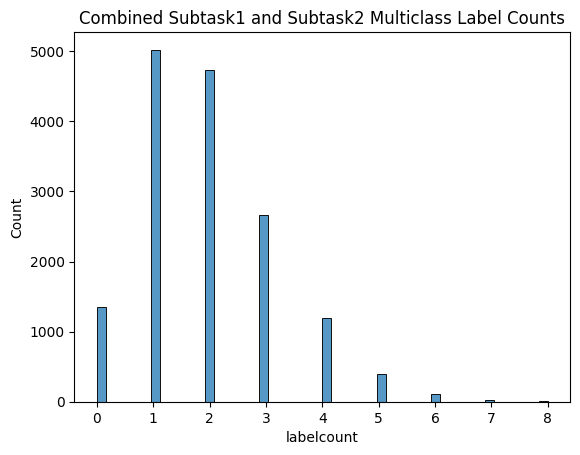

In [6]:
sns.histplot(subtask1_2a, x='labelcount').set_title('Combined Subtask1 and Subtask2 Multiclass Label Counts')

c:\users\goat\appdata\local\programs\python\python38\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


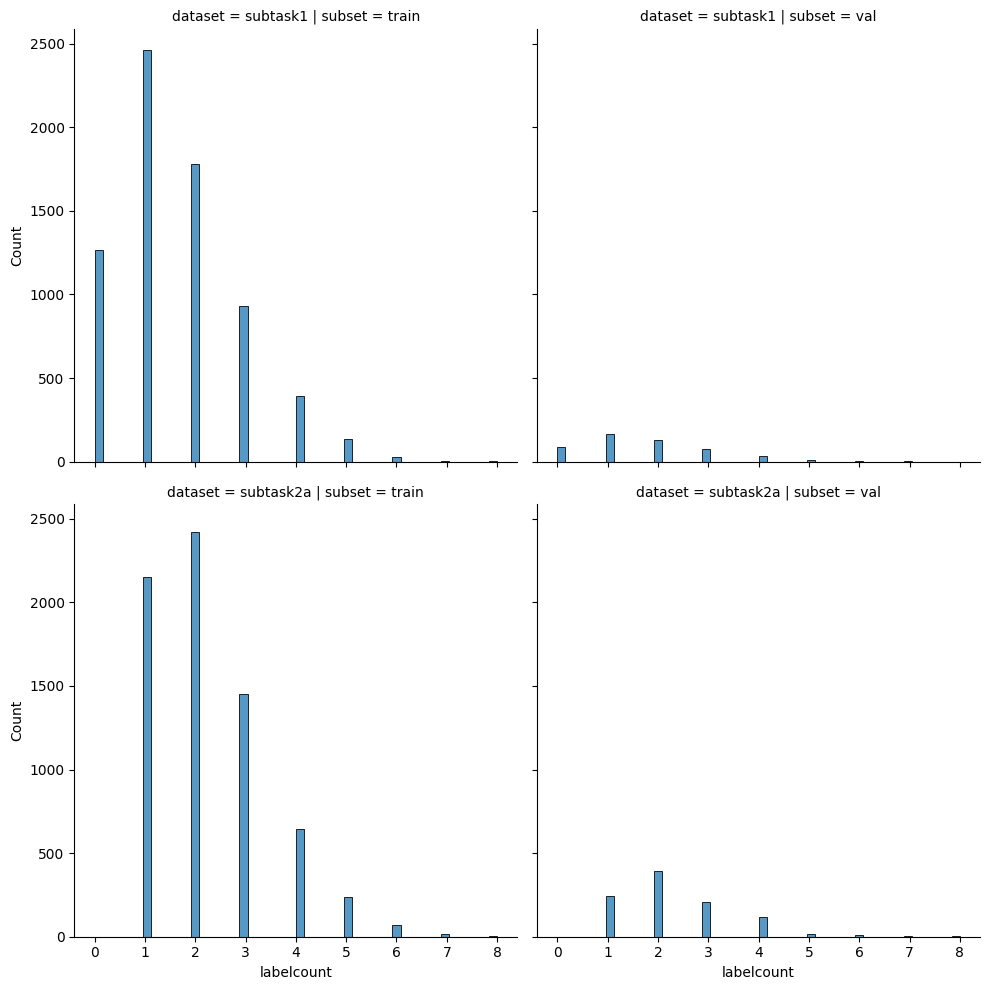

In [7]:
sns.displot(data=subtask1_2a, col='subset', row='dataset', x='labelcount')

Next step would be look at the crossover between the classes in the diagram/hierarchy, but need to finish JRC helper for this and get a better diagram of the different classes than the one provided by the authors

## Label Distribution for Subtask2b

Text(0.5, 1.0, 'Combined Subtask1 and Subtask2 Multiclass Label Counts')

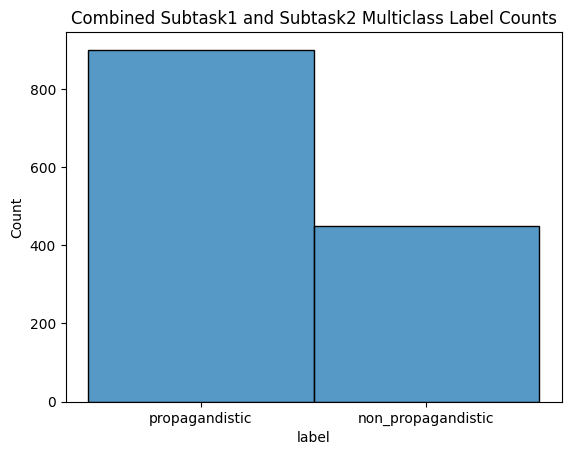

In [8]:
sns.histplot(subtask2b, x='label').set_title('Combined Subtask1 and Subtask2 Multiclass Label Counts')

c:\users\goat\appdata\local\programs\python\python38\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


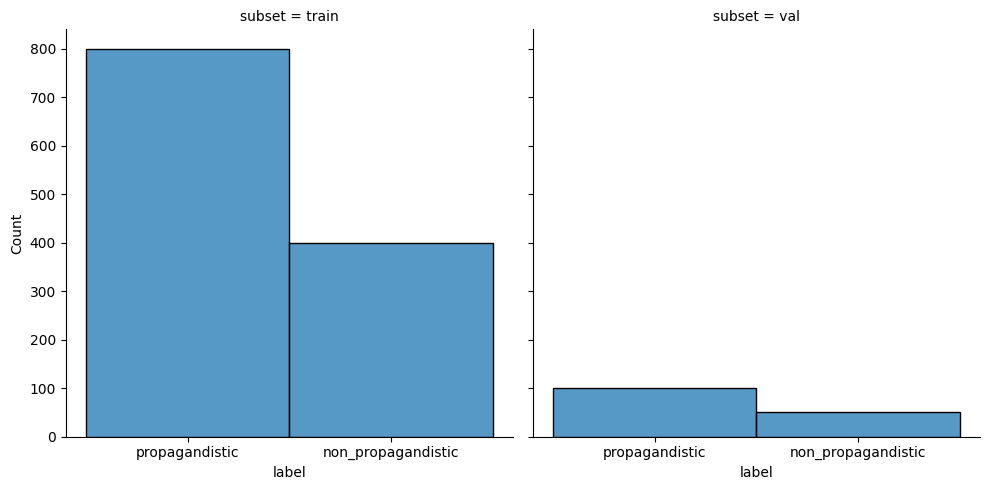

In [9]:
sns.displot(data=subtask2b, col='subset', x='label')

# Text Analysis

## Word Clouds

In [10]:
# can't fully get rid of linebreaks, but all good
stop_words = stopwords.words('english') 

def generate_wc(data, title):
    cloud = WordCloud(width=400,
                      height=330,
                      stopwords=stop_words,
                      collocations=True).generate_from_text(' '.join(s for s in data))
    plt.figure(figsize=(10,8))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title, fontsize=13)
    plt.show()

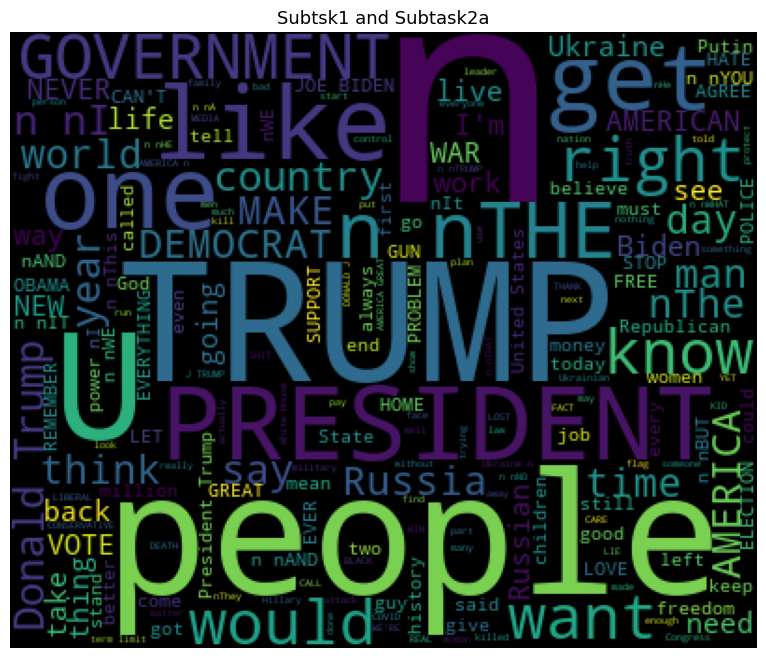

In [11]:
generate_wc(subtask1_2a['text'], 'Subtsk1 and Subtask2a')

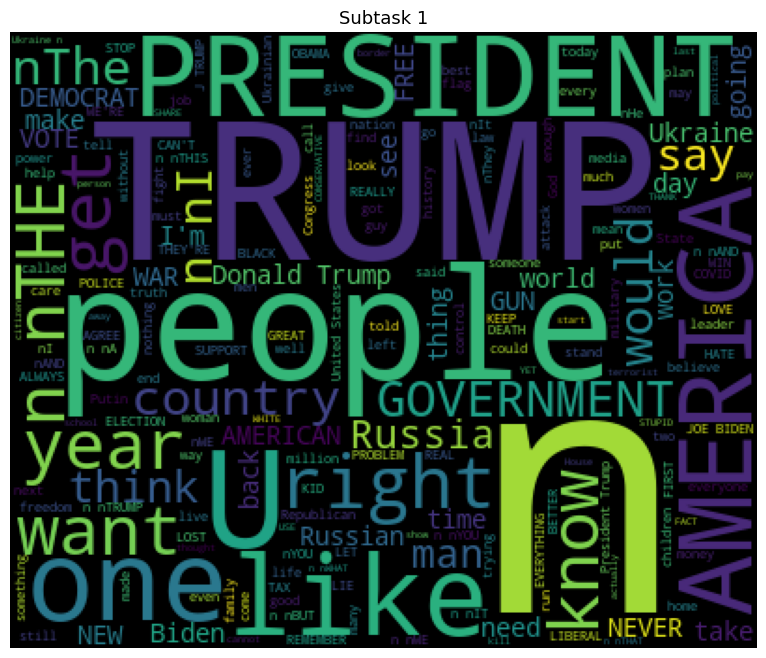

In [12]:
generate_wc(subtask1_2a[subtask1_2a['dataset'] == 'subtask1']['text'], 'Subtask 1')

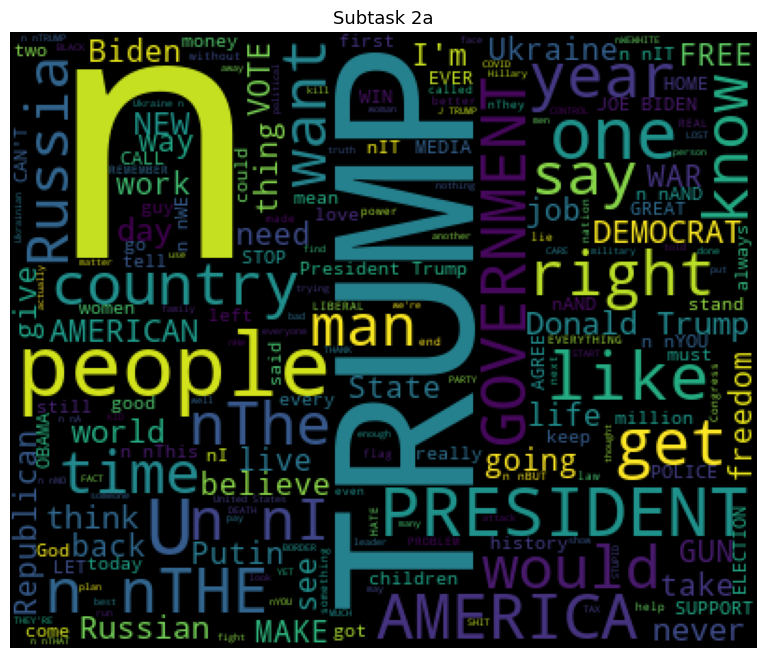

In [13]:
generate_wc(subtask1_2a[subtask1_2a['dataset'] == 'subtask2a']['text'], 'Subtask 2a')

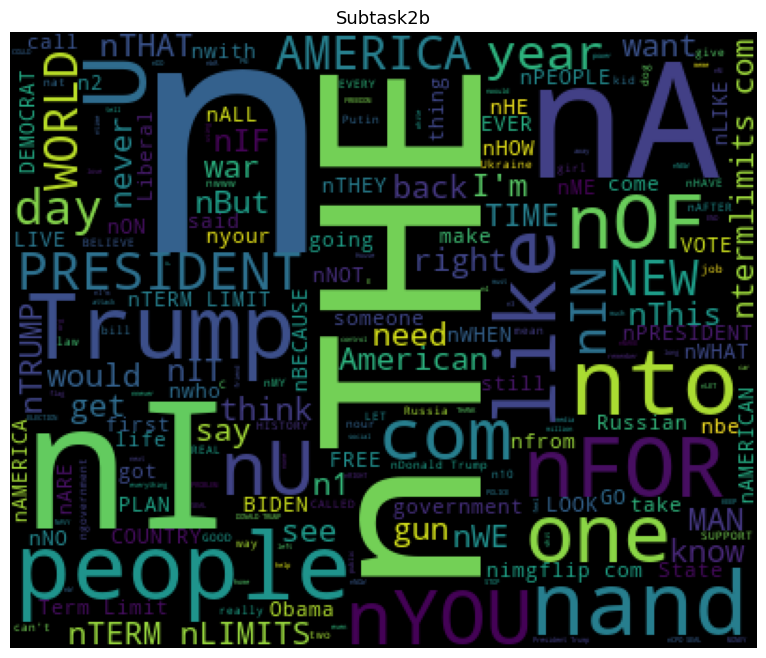

In [14]:
generate_wc(subtask2b['text'], 'Subtask2b')

## Frequency Per Class

For this part, we will explode the label lists to duplicate a row per label. Ideally, the goal would be to investigate whether certain named entities tend to appear in each type of technique over others; anything we can gather from the terminology used; specific sentiment .etc. 

Given the word clouds show highly similar words per subset, we're just going to use the combined subtask1 and subtask2a frame for this, ignoring subtask2b which is a binary classification task.

TODO:
- Add stopwords
- Different tokenizer method/get rid of boring words like 'the'
- ESCAPE CHARACTERS

In [15]:
# try to clean those pesky escape characters

subtask1_2a['text'] = subtask1_2a['text'].str.encode('ascii', 'ignore').str.decode('ascii')
subtask1_2a['text'] = subtask1_2a['text'].str.replace('\r\n',' ').replace('\n',' ')
subtask1_2a['text'] = subtask1_2a['text'].str.replace('\\n',' ').replace('\\\\n',' ')
subtask1_2a['text']

0       THIS IS WHY YOU NEED  A SHARPIE WITH YOU AT AL...
1       GOOD NEWS!  NAZANIN ZAGHARI-RATCLIFFE AND ANOO...
2                                 PAING PHYO MIN IS FREE!
3       Move your ships away!  oooook  Move your ships...
4                WHEN YOU'RE THE FBI, THEY LET YOU DO IT.
                              ...                        
7995    While Revolutionaries as Individuals can be mu...
7996    A War in the Middle East  Every US President I...
7997    A War in the Middle East  Every US President I...
7998    POLISH VS RUSSIAN HISTORY  1573  DEMOCRATIC EL...
7999    POLISH VS RUSSIAN HISTORY  1573  DEMOCRATIC EL...
Name: text, Length: 15500, dtype: object

In [16]:
#subtask1_2a['labels']=subtask1_2a['labels'].astype(str)

In [17]:
big_subtasks = subtask1_2a.explode('labels')
big_subtasks.dropna(subset='labels', inplace=True)
big_subtasks

,id,text,labels,link,subset,dataset,image,filepath,labelcount
0,65635,THIS IS WHY YOU NEED A SHARPIE WITH YOU AT AL...,Black-and-white Fallacy/Dictatorship,https://www.facebook.com/photo/?fbid=402355213...,train,subtask1,NaN,NaN,1
1,67927,GOOD NEWS! NAZANIN ZAGHARI-RATCLIFFE AND ANOO...,Loaded Language,https://www.facebook.com/amnesty/photos/531198...,train,subtask1,NaN,NaN,2
1,67927,GOOD NEWS! NAZANIN ZAGHARI-RATCLIFFE AND ANOO...,Glittering generalities (Virtue),https://www.facebook.com/amnesty/photos/531198...,train,subtask1,NaN,NaN,2
4,67641,"WHEN YOU'RE THE FBI, THEY LET YOU DO IT.",Thought-terminating cliché,https://www.facebook.com/AddictingInfoOrg/phot...,train,subtask1,NaN,NaN,1
6,79204,JANUARY 2021 YOU DON'T BUY A 12 MILLION DOLLA...,Whataboutism,https://www.facebook.com/ResistanceFeed/photos...,train,subtask1,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...
7998,67141,POLISH VS RUSSIAN HISTORY 1573 DEMOCRATIC EL...,Transfer,https://www.facebook.com/photo/?fbid=101757093...,val,subtask2a,prop_meme_11891.png,X:\PhD\SemEval Task4\Data\subtask2a_images\dev...,3
7998,67141,POLISH VS RUSSIAN HISTORY 1573 DEMOCRATIC EL...,Flag-waving,https://www.facebook.com/photo/?fbid=101757093...,val,subtask2a,prop_meme_11891.png,X:\PhD\SemEval Task4\Data\subtask2a_images\dev...,3
7999,67141,POLISH VS RUSSIAN HISTORY 1573 DEMOCRATIC EL...,Smears,https://www.facebook.com/photo/?fbid=101757093...,val,subtask2a,prop_meme_11891.png,X:\PhD\SemEval Task4\Data\subtask2a_images\val...,3
7999,67141,POLISH VS RUSSIAN HISTORY 1573 DEMOCRATIC EL...,Transfer,https://www.facebook.com/photo/?fbid=101757093...,val,subtask2a,prop_meme_11891.png,X:\PhD\SemEval Task4\Data\subtask2a_images\val...,3


In [18]:
def word_frequency(text):
    text = ' '.join(text)
    text = word_tokenize(text) #tokenized returns a few escape characters
    text = ' '.join(text)
    
    wordcloud = WordCloud(stopwords = stop_words,
                      collocations=True).generate(text)
    
    text_dictionary = wordcloud.process_text(text)
    word_freq = {k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}
    rel_freq=wordcloud.words_
    
    print(list(word_freq.items())[:20])
    print(list(x for x in rel_freq.items())[:20])

In [17]:
labels = big_subtasks['labels'].unique()

for i in labels:
    print(f'{i} Frequency')
    print('\n---')
    word_frequency(big_subtasks[big_subtasks['labels'] == i]['text'])
    print('\n--------------')

Black-and-white Fallacy/Dictatorship Frequency

---
[("n't", 246), ('people', 153), ('one', 117), ('LIKE', 104), ('Trump', 103), ('Vote', 99), ('AMERICA', 99), ('U', 98), ('right', 95), ('want', 93), ('STOP', 89), ('Ukraine', 88), ('must', 85), ('would', 83), ('NEVER', 82), ('country', 82), ('GET', 81), ('LET', 79), ('GOVERNMENT', 78), ('TIME', 75)]
[("n't", 1.0), ('people', 0.6219512195121951), ('one', 0.47560975609756095), ('LIKE', 0.42276422764227645), ('Trump', 0.4186991869918699), ('Vote', 0.4024390243902439), ('AMERICA', 0.4024390243902439), ('U', 0.3983739837398374), ('right', 0.3861788617886179), ('want', 0.3780487804878049), ('STOP', 0.3617886178861789), ('Ukraine', 0.35772357723577236), ('must', 0.34552845528455284), ('would', 0.33739837398373984), ('NEVER', 0.3333333333333333), ('country', 0.3333333333333333), ('GET', 0.32926829268292684), ('LET', 0.32113821138211385), ('GOVERNMENT', 0.3170731707317073), ('TIME', 0.3048780487804878)]

--------------
Loaded Language Frequency

### TF-IDF Cosine Similarity

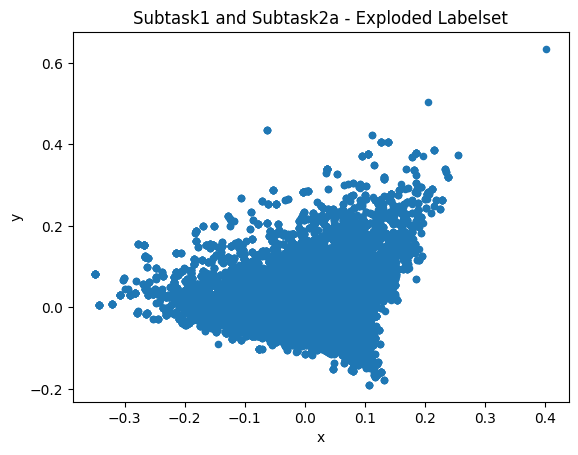

In [18]:
# run vectorizer on the joblot for now

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(raw_documents=big_subtasks['text']).toarray()

pca = PCA(n_components=2)

df2d = pd.DataFrame(pca.fit_transform(tfidf_matrix), columns=list('xy'))
# Plot Data Visualization (Matplotlib)
df2d.plot(kind='scatter', x='x', y='y')
plt.title('Subtask1 and Subtask2a - Exploded Labelset')
plt.show()

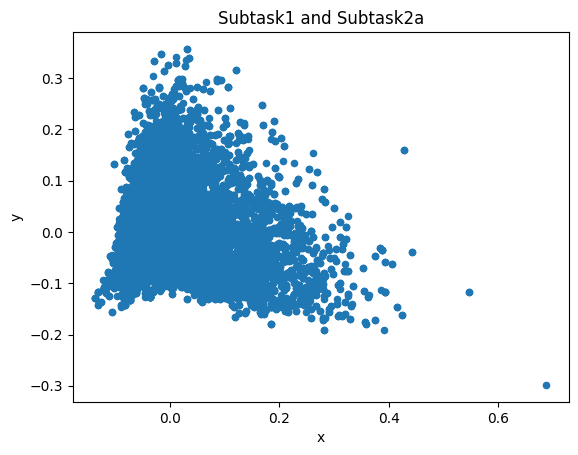

In [19]:
# let's see what the smaller set looks like (non-exploded labels), but probably will be the same and shorter range

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(raw_documents=subtask1_2a['text']).toarray()

pca = PCA(n_components=2)

df2d = pd.DataFrame(pca.fit_transform(tfidf_matrix), columns=list('xy'))
# Plot Data Visualization (Matplotlib)
df2d.plot(kind='scatter', x='x', y='y')
plt.title('Subtask1 and Subtask2a')
plt.show()

In [21]:
# make documents for all class types from the big dataset
labels = big_subtasks['labels'].unique()

document_dict = {}

for i in labels:
    doc = big_subtasks[big_subtasks['labels'] == i]['text'].tolist()
    document_dict.update({f'{i}': doc})

document_list = []

for i in labels:
    document_list += document_dict[i]  

In [143]:
vecs = vectorizer.fit_transform(document_list)
matrix = ((vecs * vecs.T).A)

for i in labels:
    dim = len(document_dict[i])
    similarity = matrix[dim:, :dim].mean()
    print(f'{i} similarity {similarity}')

Black-and-white Fallacy/Dictatorship similarity 0.02134642270802546
Loaded Language similarity 0.02095949550102712
Glittering generalities (Virtue) similarity 0.021427668204421088
Thought-terminating cliché similarity 0.021448282409803884
Whataboutism similarity 0.0214600680555694
Slogans similarity 0.021311593316859504
Causal Oversimplification similarity 0.021365774947463178
Smears similarity 0.020853602432515612
Name calling/Labeling similarity 0.02099252590022601
Appeal to authority similarity 0.0213429837391016
Exaggeration/Minimisation similarity 0.021562279631922903
Repetition similarity 0.021575291089047828
Flag-waving similarity 0.021306015039773914
Appeal to fear/prejudice similarity 0.021611710714877705
Reductio ad hitlerum similarity 0.02159105338228672
Doubt similarity 0.021572439941034978
Misrepresentation of Someone's Position (Straw Man) similarity 0.021621847785551613
Obfuscation, Intentional vagueness, Confusion similarity 0.02222189901567721
Bandwagon similarity 0.02

In [32]:
master_df = pd.DataFrame(columns=[x for x in labels], index=[x for x in labels])

for i in labels:
    for j in labels:
        corpus = [' '.join(document_dict[i]), ' '.join(document_dict[j])]
        trsfm = vectorizer.fit_transform(corpus)
        #print(cosine_similarity(trsfm))
        df = pd.DataFrame(cosine_similarity(trsfm, dense_output=True), columns=[i, j],index=[i, j])
        master_df.loc[i,j] = np.array(df)[0][1]

<Axes: >

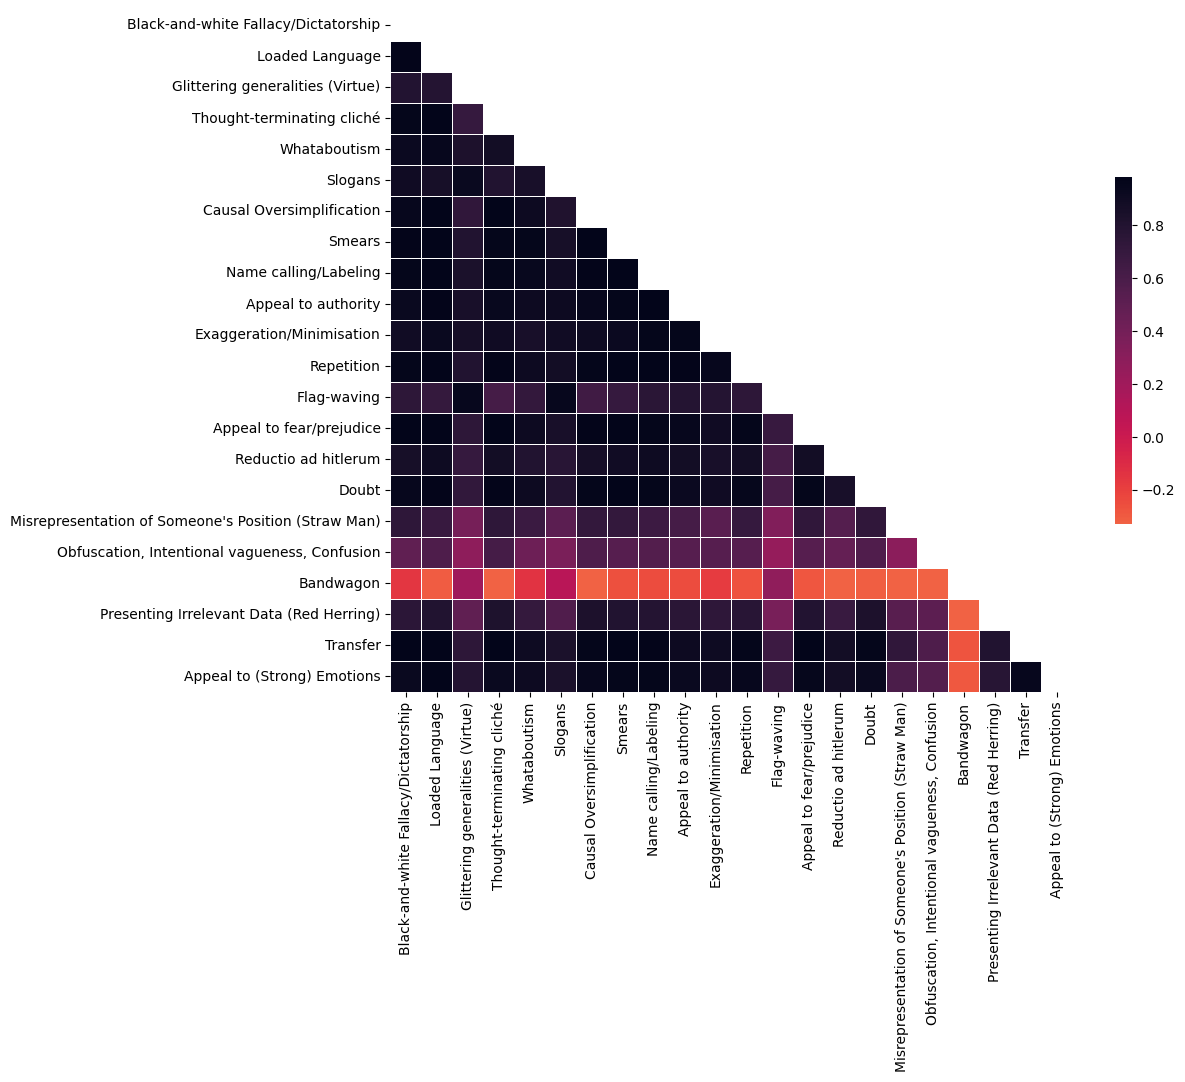

In [64]:
corr = master_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("rocket_r", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, robust=True)

In [50]:
master_df = master_df.astype(float)
master_df.style.background_gradient(cmap=cmap)

,Black-and-white Fallacy/Dictatorship,Loaded Language,Glittering generalities (Virtue),Thought-terminating cliché,Whataboutism,Slogans,Causal Oversimplification,Smears,Name calling/Labeling,Appeal to authority,Exaggeration/Minimisation,Repetition,Flag-waving,Appeal to fear/prejudice,Reductio ad hitlerum,Doubt,Misrepresentation of Someone's Position (Straw Man),"Obfuscation, Intentional vagueness, Confusion",Bandwagon,Presenting Irrelevant Data (Red Herring),Transfer,Appeal to (Strong) Emotions
Black-and-white Fallacy/Dictatorship,1.000000,0.982059,0.945438,0.977669,0.953227,0.962772,0.962660,0.980346,0.976939,0.962776,0.947684,0.967097,0.943992,0.974394,0.929486,0.962484,0.914102,0.873519,0.822074,0.912627,0.978931,0.955288
Loaded Language,0.982059,1.000000,0.959898,0.978123,0.972068,0.965046,0.979703,0.991367,0.991391,0.977527,0.967374,0.979846,0.947390,0.982882,0.950928,0.974579,0.912315,0.891777,0.802041,0.930940,0.982359,0.976750
Glittering generalities (Virtue),0.945438,0.959898,1.000000,0.932685,0.944408,0.955860,0.932109,0.965506,0.966510,0.959604,0.952243,0.944072,0.964523,0.933946,0.902647,0.934554,0.853900,0.839099,0.839414,0.873456,0.942218,0.934351
Thought-terminating cliché,0.977669,0.978123,0.932685,1.000000,0.943413,0.953243,0.968757,0.976682,0.976888,0.967376,0.956897,0.971130,0.925711,0.973176,0.934985,0.969732,0.910642,0.888091,0.774543,0.921248,0.975627,0.950945
Whataboutism,0.953227,0.972068,0.944408,0.943413,1.000000,0.936730,0.949936,0.974591,0.964575,0.952808,0.926543,0.947022,0.918151,0.950079,0.902170,0.950908,0.884424,0.839377,0.785956,0.886195,0.949841,0.946016
Slogans,0.962772,0.965046,0.955860,0.953243,0.936730,1.000000,0.942140,0.963154,0.966208,0.965197,0.947712,0.957785,0.969391,0.954638,0.908669,0.939731,0.871375,0.849029,0.826287,0.879600,0.955480,0.938285
Causal Oversimplification,0.962660,0.979703,0.932109,0.968757,0.949936,0.942140,1.000000,0.974989,0.972459,0.964484,0.950149,0.960241,0.922897,0.964993,0.921497,0.959756,0.898081,0.869144,0.766671,0.916379,0.962477,0.952586
Smears,0.980346,0.991367,0.965506,0.976682,0.974591,0.963154,0.974989,1.000000,0.989439,0.972557,0.963589,0.974211,0.942805,0.976270,0.945413,0.977478,0.919695,0.890154,0.818166,0.932839,0.985511,0.967385
Name calling/Labeling,0.976939,0.991391,0.966510,0.976888,0.964575,0.966208,0.972459,0.989439,1.000000,0.979693,0.975456,0.981510,0.951720,0.972549,0.947686,0.973748,0.909548,0.888810,0.810611,0.925894,0.979262,0.966824
Appeal to authority,0.962776,0.977527,0.959604,0.967376,0.952808,0.965197,0.964484,0.972557,0.979693,1.000000,0.965166,0.967343,0.951371,0.964190,0.934065,0.956633,0.886265,0.870258,0.780278,0.911521,0.953229,0.948140


<Axes: >

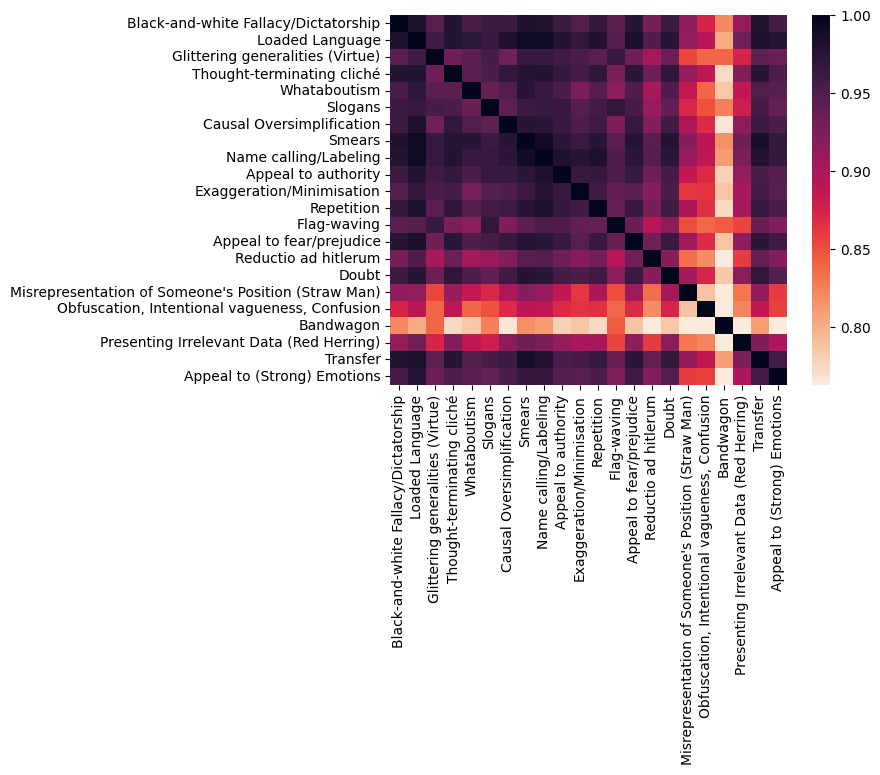

In [61]:
sns.heatmap(master_df, cmap='rocket_r', robust=True)